In [1]:
import sys
import os

# Add the top-level surface_properties/surface_properties directory to the path
sys.path.append(os.path.abspath(".."))

from analysis.Base import AnalysisBase
from analysis.Order import OrderParameters
from analysis.Vector import VectorOrientation
from analysis import Surface

import analysis.opc
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import logging

In [2]:
u = mda.Universe('../../../../../mlx_v2/6.6_2.gro', '../../../../../mlx_v2/old_trajs/rep1_skip10.xtc')

# Scd for PL membrane. Includes distances from protein

In [6]:
halfz = u.dimensions[2] / 2
start_frame = 980
end_frame = 1000

# Far from protein
selection_far = f"resname POPC and (around 30 protein) and (not around 20 protein) and prop z > {halfz}"
op_far = OrderParameters(
    u, atomlists=analysis.opc.POPC1,
    selection=selection_far,
    start=start_frame, stop=end_frame
)
op_far.run()
res_far = op_far.results['output']

# Near protein
selection_near = f"resname POPC and (around 10 protein) and prop z > {halfz}"
op_near = OrderParameters(
    u, atomlists=analysis.opc.POPC1,
    selection=selection_near,
    start=start_frame, stop=end_frame
)
op_near.run()
res_near = op_near.results['output']


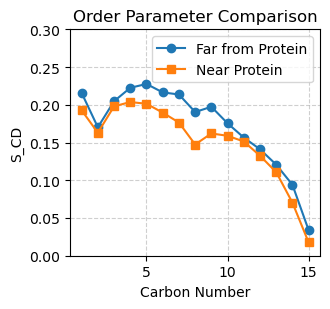

In [7]:
carbons = res_far[:, 0]
scd_far = res_far[:, 1]
scd_near = res_near[:, 1]

plt.figure(figsize=(3.4, 3.2))
plt.plot(carbons, scd_far, label='Far from Protein', marker='o')
plt.plot(carbons, scd_near, label='Near Protein', marker='s')
plt.xlabel("Carbon Number")
plt.ylabel("S_CD")
plt.title("Order Parameter Comparison")
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 0.3)
plt.legend()
plt.tight_layout()
plt.show()


# For SURF-TG


In [12]:
logger = logging.getLogger(__name__)

interdig_analysis = Surface.InterdigitationAnalysis(u, lipids=['POPC', 'DOPE', 'SAPI'], NL='TRIO', water='TIP3')
interdig_analysis.setup_groups()


results_u = interdig_analysis.interdigit(b=100, e=200)
strong_u = results_u['strong_residues']

start_frame = 100

def get_dynamic_strong_residues(ts, name=strong_u, start_frame=start_frame):
    current_frame = ts.frame - start_frame
    if 0 <= current_frame < len(name):
        residues = name[current_frame]
        logger.info(f"Frame {ts.frame}: Strong residues = {residues}")
        return residues
    else:
        logger.info(f"Frame {ts.frame}: No strong residues available.")
        return []

    

# Run with dynamic residue selection
op = OrderParameters(
    u,
    atomlists=analysis.opc.TRIO1,  # or TRIO3 or whatever head/tail mapping you want
    selection=None,
    get_strong_residues=get_dynamic_strong_residues,
    start=100,
    stop=200
)

op.run()

np.savetxt("surf_test.dat", op.results['output'])
surf_results = op.results['output']

    

Using tail atoms: ['C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C210', 'C211', 'C212', 'C213', 'C214', 'C215', 'C216', 'C217', 'C218', 'C219', 'C220', 'C221', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C310', 'C311', 'C312', 'C313', 'C314', 'C315', 'C316', 'C317', 'C318', 'C319', 'C320', 'C321']
Final selected tail atoms in memb: ['C22' 'C32' 'C23' ... 'C316' 'C317' 'C318']
setup_groups() completed!


Processing frames: 100%|███████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.68frame/s]


units: Z (nm), interdigitation (nm), time (ns), density (g/m3)


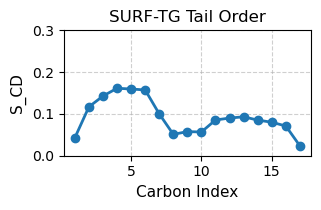

In [14]:

carbons = surf_results[:, 0]
scd = surf_results[:, 1]

# Plot
plt.figure(figsize=(3.4, 2.2))
plt.plot(carbons, scd, marker='o', linestyle='-', linewidth=2)

plt.xlabel("Carbon Index", fontsize=11)
plt.ylabel("S_CD", fontsize=11)
plt.title("SURF-TG Tail Order", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 0.3)
plt.tight_layout()
plt.show()


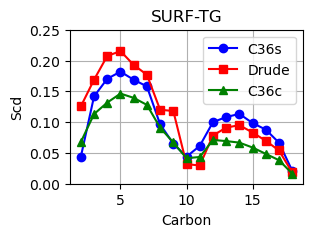

In [6]:
def plot_surf(u1='surf_c36s.dat', u2='surf_drude.dat', u3='surf_c36c.dat'):
    surf1 = np.loadtxt(u1)
    surf2 = np.loadtxt(u2)
    surf3 = np.loadtxt(u3)  

    carbon_numbers = surf1[:, 0]
    op1 = surf1[:, 1]
    op2 = surf2[:, 1]
    op3 = surf3[:, 1]

    # Plot the data
    plt.figure(figsize=(3, 2)) 
    plt.plot(carbon_numbers, op1, marker='o', linestyle='-', color='b', label='C36s')
    plt.plot(carbon_numbers, op2, marker='s', linestyle='-', color='r', label='Drude')
    plt.plot(carbon_numbers, op3, marker='^', linestyle='-', color='g', label='C36c')
    plt.xlabel('Carbon')
    plt.ylabel('Scd')
    plt.title('SURF-TG')
    plt.ylim(0,0.25)
    plt.legend()
    plt.grid(True)
    plt.savefig('order_tg.png',dpi=600, bbox_inches='tight')
    plt.show()

# Call the function with file names
u1 = 'surf_c36s.dat'
u2 = 'surf_drude.dat'
u3 = 'surf_c36c.dat'

plot_surf(u1, u2, u3)


# Cosine alignment

In [3]:
vo = VectorOrientation(
    universe=u,
    start=0,
    stop=1000,
    step=10,
    residue_sel="resname TRIO",
    tail_names=["C118", "C218", "C318"],
    headgroup_sel="name O*",
    pl_selection="resname POPC DOPE and name C210",
    leaflet='bottom',
    expected_headgroup_count=6
)


angles, time_series, avg_op, std_op = vo.run().unpack()



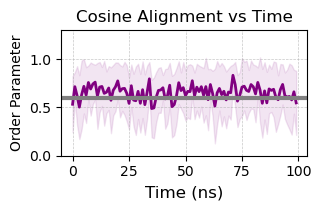

In [4]:
tail_names = ["C118", "C218", "C318"]
avg_values_combined = np.nanmean([np.array(avg_op[tail]) for tail in tail_names], axis=0)
std_values_combined = np.nanmean([np.array(std_op[tail]) for tail in tail_names], axis=0)
time_series_array = np.array(time_series)
valid_mask = ~np.isnan(avg_values_combined)

# Create plot
plt.figure(figsize=(3.4, 2.2))
plt.plot(
    time_series_array[valid_mask] / 10,  # convert to ns
    avg_values_combined[valid_mask],
    color='purple',
    linewidth=2
)
plt.fill_between(
    time_series_array[valid_mask] / 10,
    avg_values_combined[valid_mask] - std_values_combined[valid_mask],
    avg_values_combined[valid_mask] + std_values_combined[valid_mask],
    color='purple',
    alpha=0.1
)

plt.axhline(0.6, color='gray', linestyle='-', linewidth=3)

plt.xlabel("Time (ns)", fontsize=12)
plt.ylabel("Order Parameter", fontsize=10)
plt.title("Cosine Alignment vs Time", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
angles_df = pd.DataFrame(angles)
df_avg = pd.DataFrame(avg_op)
df_std = pd.DataFrame(std_op)
df_avg['frame'] = time_series
df_std['frame'] = time_series

avg_long = df_avg.melt(id_vars='frame', var_name='tail_name', value_name='avg_order')
std_long = df_std.melt(id_vars='frame', var_name='tail_name', value_name='std_order')

# Merge avg + std
order_df = pd.merge(avg_long, std_long, on=['frame', 'tail_name'])


In [7]:
import sqlite3

conn = sqlite3.connect('orientation_analysis.db')

# Save both tables
angles_df.to_sql('angles', conn, if_exists='replace', index=False)
order_df.to_sql('order_summary', conn, if_exists='replace', index=False)

conn.close()
